In [1]:
from proxbias.depmap.process import compute_monte_carlo_stats
from proxbias.depmap.load import get_depmap_data
from proxbias.utils.data_utils import get_cancer_gene_lists
from proxbias.metrics import genome_proximity_bias_score
from proxbias.depmap.constants import *

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import pickle
import ast
import random

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
crispr_effect, _, cnv_data, mutation_data = get_depmap_data(rnai_release="")
oncogenes, tsgs = get_cancer_gene_lists(crispr_effect.index)

CRISPRGeneEffect.csv from DepMap Public 22Q4 is found. Reading dataframe from cache.
Done!
OmicsCNGene.csv from DepMap Public 22Q4 is found. Reading dataframe from cache.
Done!
OmicsSomaticMutations.csv from DepMap Public 22Q4 is found. Reading dataframe from cache.
Done!


In [4]:
#write a function that performs a t-test for the bootstrap estimates
def perform_t_test(df: pd.DataFrame) -> pd.DataFrame:
    df = df.reset_index().rename(columns={'index': 'gene'})

    # Initialize t_stat and p_value columns in the original DataFrame
    df['t_stat'] = None
    df['p_value'] = None

    for index, row in df.iterrows():
        test_stats = row['test_stats']
        wt_stats = row['wt_stats']

        # Perform the t-test
        t_stat, p_value = stats.ttest_ind(test_stats, wt_stats)
        
        # Assign t_stat and p_value to the respective columns in the DataFrame
        df.at[index, 't_stat'] = t_stat
        df.at[index, 'p_value'] = p_value
    
    return df
pd.options.display.float_format = '{:.10e}'.format

In [5]:
### write a function to scramble a given column's values
def scramble_column(df: pd.DataFrame, column_name: str = 'ModelID', seed: int = None) -> pd.DataFrame:
    scrambled_df = df.copy()
    
    # Check if the specified column is in the DataFrame
    if column_name in scrambled_df.columns:
        # Extract the specified column
        column_values = scrambled_df[column_name].tolist()
    else:
        # Extract the index if the column is not a regular column
        column_values = scrambled_df.index.tolist()
    
    # Shuffle the column values list with the specified seed
    if seed is not None:
        random.seed(seed)
    random.shuffle(column_values)
    
    # Assign the scrambled column values list back to the DataFrame
    if column_name in scrambled_df.columns:
        scrambled_df[column_name] = column_values
    else:
        scrambled_df.index = column_values
    
    return scrambled_df

### write a function to scramble column names
def scramble_column_names(df: pd.DataFrame, seed: int = None) -> pd.DataFrame:
    scrambled_df = df.copy()
    column_names = list(scrambled_df.columns)

    # Shuffle column names list with the specified seed
    if seed is not None:
        random.seed(seed)
    random.shuffle(column_names)

    # Assign scrambled column names back to the DataFrame
    scrambled_df.columns = column_names
    return scrambled_df


In [6]:
#write a function that creates a permuted null across many shufflings of the data
def permute_null_t_test(mutation_data,
                        crispr_effect,
                        cnv_data,
                        n_shuffles,
                        n_min_cell_lines=25,
                        genes=["TP53"],
                        candidate_models=list(crispr_effect.columns),
                        eval_kwargs={"n_samples": 500, "n_trials": 200, "return_samples": False},
                        **kwargs):
    permuted_null_t_test = pd.DataFrame()

    #put observed results in dataframe
    observed_data = compute_monte_carlo_stats(
            genes_of_interest=genes,
            dependency_data=crispr_effect,
            cnv_data=cnv_data,
            mutation_data=mutation_data,
            n_min_cell_lines=n_min_cell_lines,
            candidate_models=candidate_models,
            eval_function=genome_proximity_bias_score,
            eval_kwargs=eval_kwargs,
            seed=42,
            n_workers=4,
            **kwargs
        )
    
    observed_data['seed'] = 42
    observed_data['result_type'] = "observed"
    observed_data = perform_t_test(observed_data)


    random_seeds = [random.randint(1, 100000) for _ in range(n_shuffles)]

    for seed in random_seeds:
        scrambled_crispr_effect = scramble_column_names(crispr_effect, seed=seed)  # Use a single seed for scrambling
        
        # Perform t-test for each gene
        scrambled_res_gene = compute_monte_carlo_stats(
            genes_of_interest=genes,
            dependency_data=scrambled_crispr_effect,
            cnv_data=cnv_data,
            mutation_data=mutation_data,
            n_min_cell_lines=n_min_cell_lines,
            candidate_models=candidate_models,
            eval_function=genome_proximity_bias_score,
            eval_kwargs=eval_kwargs,
            seed=seed,
            n_workers=4,
            **kwargs
        )
        
        # Add a column for the seed
        scrambled_res_gene['seed'] = seed
        scrambled_res_gene['result_type'] = "empirical_null"
        scrambled_res_gene = perform_t_test(scrambled_res_gene)
        
        # Concatenate the result with the existing DataFrame
        permuted_null_t_test = pd.concat([permuted_null_t_test, scrambled_res_gene], ignore_index=True)
    
    permuted_null_t_test = pd.concat([observed_data, permuted_null_t_test], ignore_index=True).sort_values(["gene", "seed"])
    return permuted_null_t_test

#quick test of permuted null
permuted_null = permute_null_t_test(mutation_data,
                                    crispr_effect,
                                    cnv_data,
                                    n_shuffles=2,
                                    n_iterations=5)

permuted_null

In [ ]:
#subset to cell lines with less than 1% CNVs
cnv_data_trans = 2 * (np.power(2, cnv_data) - 1)
cnv_calls = (cnv_data_trans < 1.75) | (cnv_data_trans > 2.25)
cnv_call_pers = cnv_calls.mean(axis=0).sort_values(ascending=False)
least_cnv_cl_01 = list(set(cnv_call_pers[cnv_call_pers < 0.01].index)) #there are only 21 of these cell lines, so these werent used for the driver analysis

#all columns
all_columns = set(cnv_data.columns).intersection(set(crispr_effect.columns)).intersection(set(mutation_data['ModelID']))

# Get p53 loss-of-function (lof) cell lines
tp53_loss_cell_lines = set(cnv_data_trans.T[["TP53"]].query("TP53 <= 1.5").index).intersection(all_columns)

# Get p53 wild-type (wt) cell lines
tp53_wt = all_columns - tp53_loss_cell_lines

# Convert sets to lists
tp53_copy_loss = list(tp53_loss_cell_lines)
tp53_wt = list(tp53_wt)

# Subset the mutation dataframes by P53 status
p53_lof_mutation_data = mutation_data[mutation_data['ModelID'].isin(tp53_copy_loss)]
p53_lof_crispr_effect = crispr_effect[tp53_copy_loss]

p53_wt_mutation_data = mutation_data[mutation_data['ModelID'].isin(tp53_wt)]
p53_wt_crispr_effect = crispr_effect[tp53_wt]

In [ ]:
#write a function that either reads null from disc or creates it
def load_or_create_permuted_null(file_name, mutation_data, crispr_effect, cnv_data, search_mode, n_shuffles=100, genes=["CDKN2A", "CDKN2B", "CDKN2C", "BTG2", "MDM4", "MDM2"], fixed_cell_line_sampling=True):
    if os.path.exists(file_name):
        return pd.read_csv(file_name, sep="\t")
    else:
        permuted_null = permute_null_t_test(
            mutation_data,
            crispr_effect,
            cnv_data,
            n_shuffles=n_shuffles, #for empirical null generation
            genes=genes,
            n_iterations=128,
            search_mode=search_mode,
            n_min_cell_lines=25,
            fixed_cell_line_sampling=fixed_cell_line_sampling,
            candidate_models=list(crispr_effect.columns),
            cnv_cutoffs=(1.5, 2.5),
            filter_amp=True,
            eval_kwargs={"n_samples": 20, "n_trials": 200, "return_samples": False}
        )
        permuted_null.to_csv(file_name, sep="\t")
        return permuted_null

In [ ]:
p53_only_permuted_null = load_or_create_permuted_null(
    "p53_only_permuted_null.txt",
    mutation_data,
    crispr_effect,
    cnv_data,
    n_shuffles=100,
    search_mode="lof",
    genes=["TP53"],
    fixed_cell_line_sampling=False)

In [ ]:
p53_lof_permuted_null_LOF = load_or_create_permuted_null(
    "p53_lof_permuted_null_LOF_genes.txt",
    p53_lof_mutation_data,
    p53_lof_crispr_effect,
    cnv_data,
    n_shuffles=100,
    search_mode="lof"
)

In [ ]:
p53_lof_permuted_null_AMP = load_or_create_permuted_null(
    "p53_lof_permuted_null_AMP_genes.txt",
    p53_lof_mutation_data,
    p53_lof_crispr_effect,
    cnv_data,
    n_shuffles=100,
    search_mode="amp"
)

In [ ]:
p53_wt_permuted_null_LOF = load_or_create_permuted_null(
    "p53_wt_permuted_null_LOF_genes.txt",
    p53_wt_mutation_data,
    p53_wt_crispr_effect,
    cnv_data,
    n_shuffles=100,
    search_mode="lof"
)

In [ ]:
p53_wt_permuted_null_AMP = load_or_create_permuted_null(
    "p53_wt_permuted_null_AMP_genes.txt",
    p53_wt_mutation_data,
    p53_wt_crispr_effect,
    cnv_data,
    n_shuffles=100,
    search_mode="amp"
)

### Compute Empirical Null for LoF Drivers on P53 LoF

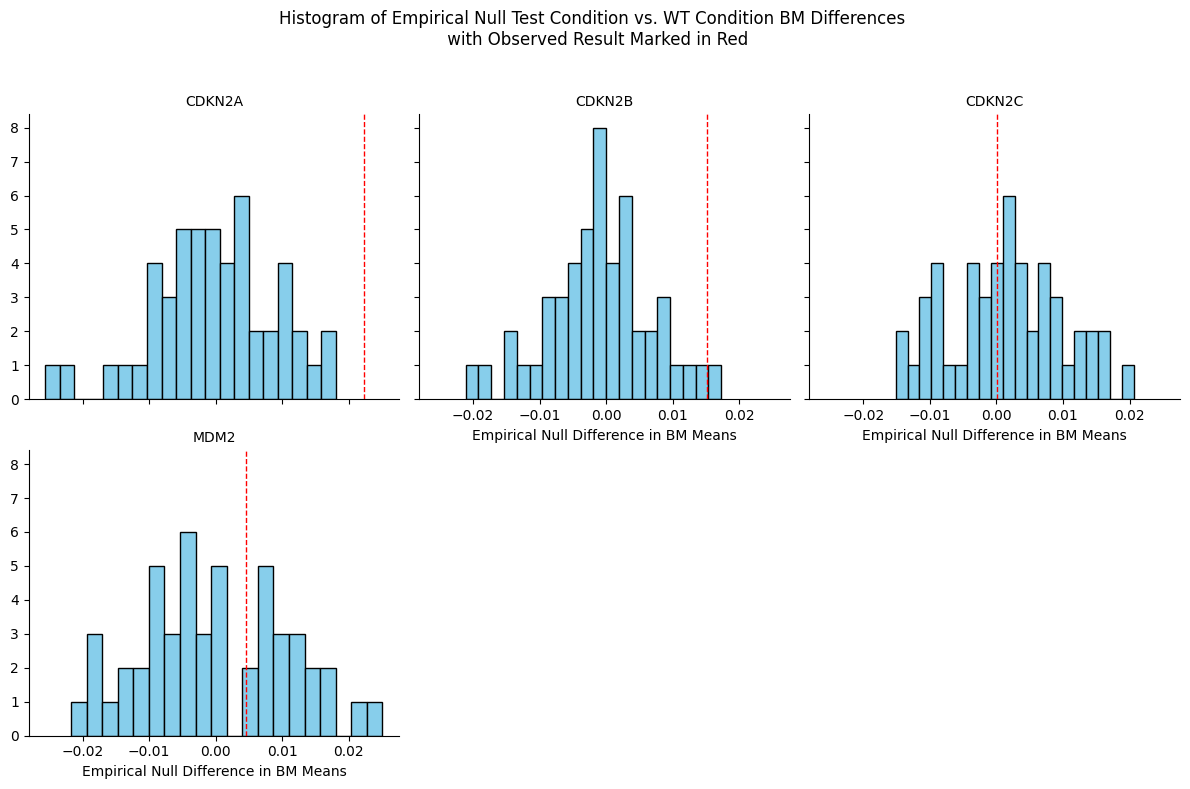

In [ ]:
def plot_empirical_null_histogram(df, gene_column='gene'):
    """
    Plot histograms of 'empirical_null' diff values faceted by gene,
    with observed values marked by vertical red lines if they exist.

    Parameters:
    - df: pandas DataFrame containing the data
    - gene_column: name of the column to use for grouping (default: 'gene')

    Returns:
    - None (displays the plot)
    """
    # Filter data for "empirical_null" result_type
    df_empirical_null = df[df['result_type'] == 'empirical_null']

    # Find genes with "observed" values
    genes_with_observed = df[df['result_type'] == 'observed'][gene_column].unique()

    # Filter the empirical null data to only include genes with observed values
    df_empirical_null = df_empirical_null[df_empirical_null[gene_column].isin(genes_with_observed)]

    # FacetGrid with seaborn
    g = sns.FacetGrid(df_empirical_null, col=gene_column, col_wrap=3, height=4)

    # Plot histogram for each gene
    g.map(plt.hist, 'diff', bins=20, color='skyblue', edgecolor='black')

    # Add a vertical red line for the "observed" value in each facet
    for ax, gene in zip(g.axes.flat, df_empirical_null[gene_column].unique()):
        observed_diff = df[(df[gene_column] == gene) & (df['result_type'] == 'observed')]['diff'].values[0]
        ax.axvline(x=observed_diff, color='red', linestyle='--', linewidth=1)
        ax.set_xlabel('Empirical Null Difference in BM Means')

    # Adjust layout and display plot
    g.set_titles("{col_name}")
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle('Histogram of Empirical Null Test Condition vs. WT Condition BM Differences \n with Observed Result Marked in Red')
    plt.show()

# Example usage:
# Assuming df is your pandas DataFrame with the provided data
plot_empirical_null_histogram(p53_lof_permuted_null_LOF, gene_column='gene')
